# BUILD AUTOENCODER FROM SCRATCH

### 1. Import all dependencies

In [1]:
import pandas as pd

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

### 2. Prepared Dataset


In [2]:
class MNISTDataset(Dataset):
    def __init__(self, csv_path : str, transform : transforms):
        super().__init__()
        self.data = pd.read_csv(csv_path)
        self.transform = transform

        # split dataset into Features-Label
        self.features = self.data.iloc[:, 1:].values.astype('float32') / 255.0
        self.labels = self.data.iloc[:, 0].values.astype('int64')

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.features[index].reshape(28,28)
        lable = self.labels[index]

        # perform transformation 
        if self.transform:
            image = self.transform(image)

        return image, lable

### 2. Load MNIST Dataset 

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
    ])

csv_path = '/kaggle/input/digit-recognizer/train.csv'
mnist_data = MNISTDataset(csv_path, transform = transform)

data_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)

In [4]:
for image, label in data_loader:
    print(torch.min(image), torch.max(image) )
    break

tensor(-1.) tensor(1.)


### 3. Build AutoEncoder

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.ReLU(),

            nn.Linear(16, 12),
            nn.ReLU(),

            nn.Linear(12, 3),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),

            nn.Linear(12, 16),
            nn.ReLU(),

            nn.Linear(16, 32),
            nn.ReLU(),

            nn.Linear(32, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 28 * 28),
            nn.Tanh()  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### 3.1 Build ConvAutoEncoder

In [6]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.Conv2d(16, 32, 3, stride=2, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3),
            nn.BatchNorm2d(64),
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3),  
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),  
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),  
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### 4. Create Model

In [15]:
device = torch.device('cuda')
model1 = AutoEncoder().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(
    model1.parameters(),
    lr = 1e-3,
    weight_decay = 1e-5
)

In [8]:
device = torch.device('cuda')
model2 = ConvAutoEncoder().to(device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(
    model2.parameters(),
    lr = 1e-3,
    weight_decay = 1e-5
)

### 5. Prepare Training Loop

In [16]:
num_epochs = 20
outputs1 = []

for epoch in range(num_epochs):
    total_loss = 0
    for (image, label) in data_loader:
        # Store original images before flattening for visualization
        original_images = image.detach().cpu()[:10]

        # Flatten images for the model
        image = image.reshape(-1,28 * 28).to(device)

        # Forward pass
        reconstruct_image = model1(image)
        loss = loss_function(reconstruct_image, image)
        total_loss += loss

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Store reconstructed images
    sample_reconstructed_images = reconstruct_image.detach().cpu()[:10]

    # Append original and reconstructed images to outputs
    outputs1.append((epoch, original_images, sample_reconstructed_images))

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data_loader):.4f}")


Epoch [1/20], Loss: 0.2624
Epoch [2/20], Loss: 0.2113
Epoch [3/20], Loss: 0.1925
Epoch [4/20], Loss: 0.1867
Epoch [5/20], Loss: 0.1819
Epoch [6/20], Loss: 0.1769
Epoch [7/20], Loss: 0.1694
Epoch [8/20], Loss: 0.1646
Epoch [9/20], Loss: 0.1612
Epoch [10/20], Loss: 0.1600
Epoch [11/20], Loss: 0.1547
Epoch [12/20], Loss: 0.1512
Epoch [13/20], Loss: 0.1513
Epoch [14/20], Loss: 0.1507
Epoch [15/20], Loss: 0.1485
Epoch [16/20], Loss: 0.1477
Epoch [17/20], Loss: 0.1444
Epoch [18/20], Loss: 0.1440
Epoch [19/20], Loss: 0.1469
Epoch [20/20], Loss: 0.1431


In [10]:
for image, lable in data_loader:
    print(image.size(0))
    break

64


### 5.1 Training loop for ConvAutoEncoder

In [11]:
num_epochs = 10
outputs = []

for epoch in range(num_epochs):
    total_loss = 0

    for (image, label) in data_loader:
        # Reshape to (batch_size, 1, 28, 28)
        image = image.view(-1, 1, 28, 28).to(device)

        # Forward pass
        reconstruct_image = model2(image)
        loss = loss_function(reconstruct_image, image)
        total_loss += loss.item()

        # Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Store reconstructed images for visualization
    sample_reconstructed_images = reconstruct_image.detach().cpu()[:10]
    sample_images = image.detach().cpu()[:10]

    outputs.append((epoch, sample_images, sample_reconstructed_images))
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(data_loader):.4f}")

Epoch [1/10], Loss: 0.0671
Epoch [2/10], Loss: 0.0061
Epoch [3/10], Loss: 0.0042
Epoch [4/10], Loss: 0.0033
Epoch [5/10], Loss: 0.0028
Epoch [6/10], Loss: 0.0026
Epoch [7/10], Loss: 0.0023
Epoch [8/10], Loss: 0.0021
Epoch [9/10], Loss: 0.0020
Epoch [10/10], Loss: 0.0019


### 6. Visualization method

In [12]:
import matplotlib.pyplot as plt

def visualize_outputs(outputs, step):
    for k in range(0, num_epochs, step):
        epoch, original_images, reconstructed_images = outputs[k]

        plt.figure(figsize=(10, 4))  # Fixed and consistent figure size
        plt.gcf().set_size_inches(10, 4)  # Enforce the same size for each figure

        # Display Original Images
        for i in range(5):
            plt.subplot(2, 5, i + 1)
            plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
            plt.title("Original")
            plt.axis('off')

        # Display Reconstructed Images
        for i in range(5):
            plt.subplot(2, 5, 5 + i + 1)
            plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
            plt.title("Reconstructed")
            plt.axis('off')

        # Add Title & Spacing Control
        plt.suptitle(f'Epoch {epoch + 1}', fontsize=14, fontweight='bold')
        plt.subplots_adjust(top=0.85, wspace=0.3, hspace=0.3)  # Controlled spacing

        plt.show()

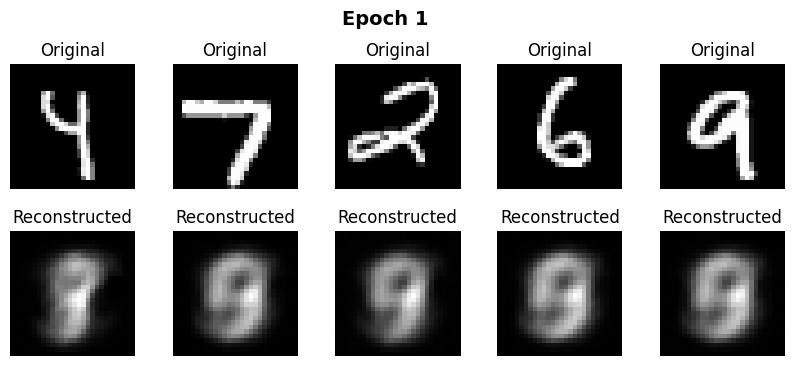

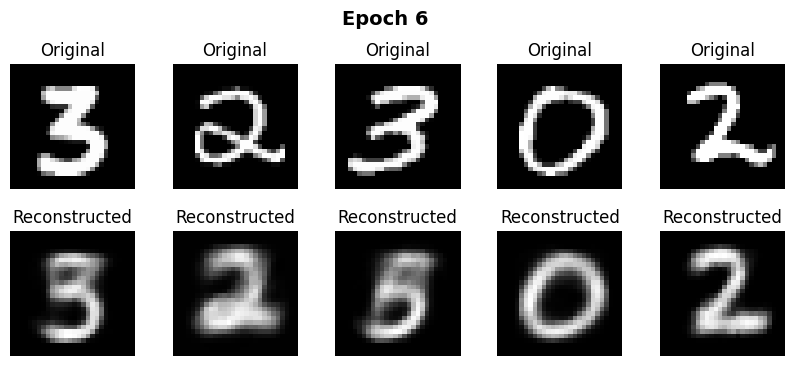

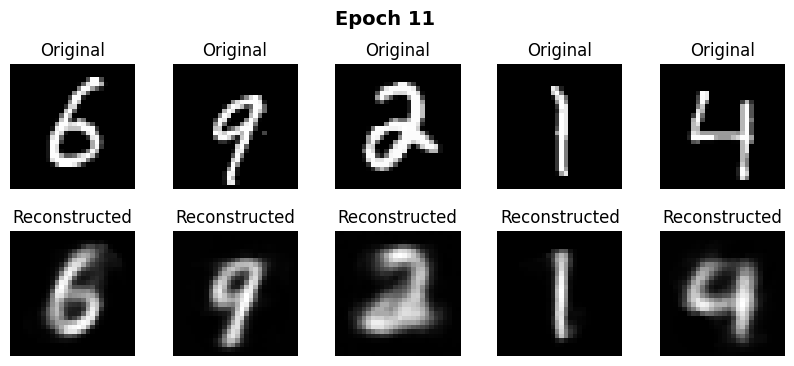

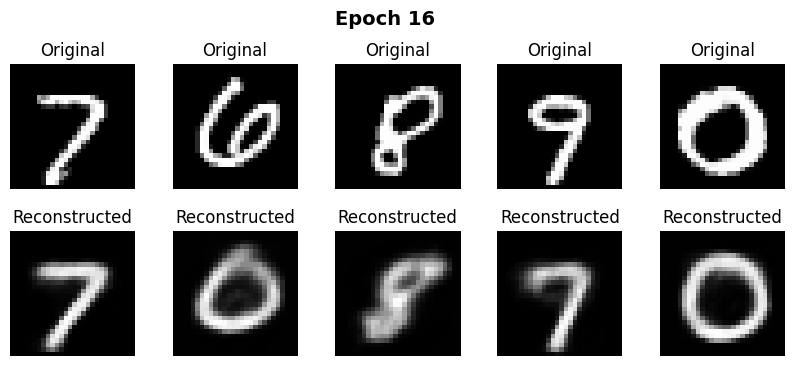

In [17]:
visualize_outputs(outputs1, 5)

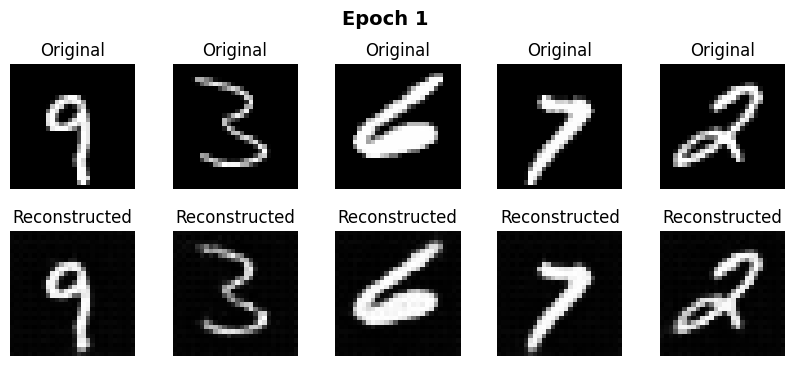

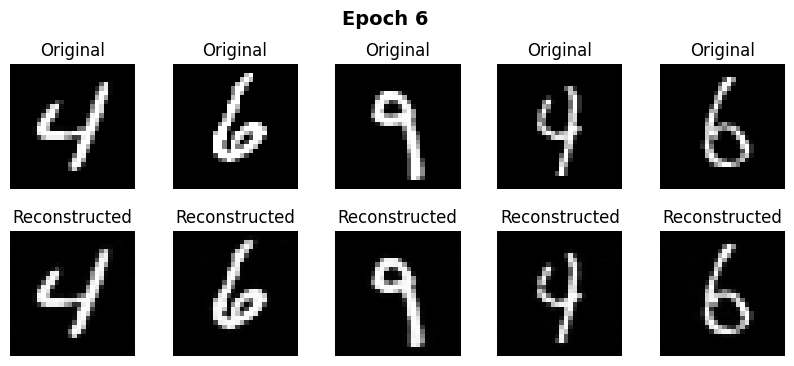

In [14]:
visualize_outputs(outputs, 5)

## --------  THE END  ---------